# Jupyter Notebook: SLAM Lidar for the detection of PM1, PM2.5 and PM10 in Underground Mining Environments

## This notebook explores the relationship between Velodyne data captured by a Hovermap 100 SLAM Lidar scanner and a Trolex Air XD Particulate Matter Monitor.

Ideally, we should be able to determine the correlation between these two datasources to assess whether there exists a meaningful way to infer particulate matter mass concentrations using Lidar.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Import Trolex Dataset

In [3]:
trolex_dataset = pd.read_csv("_data/IE01117_2024_10_4_002.trx", header=23)

Create a Timestamp object for each row

In [4]:
def create_datetime(row):
    datetime_row = datetime(2024, 10, 4, int(row['HH']), int(row['MM']), int(row["SS"]))
    return datetime_row
trolex_dataset['Timestamp'] = trolex_dataset.apply(lambda row: create_datetime(row), axis=1)

Narrow to instances where the cap is "open". This gives 423 observations, logging every 10 seconds. In total, there are 70.5 minutes (1.175 hours) of data collected.

In [5]:
trolex_dataset_open = trolex_dataset[trolex_dataset[' Status'] == 0]

Exploratory data plots:

In [ ]:
fig = plt.figure(dpi=1200)
plt.plot(trolex_dataset_open['Timestamp'], trolex_dataset_open['PMA Value'], label='PM1')
plt.plot(trolex_dataset_open['Timestamp'], trolex_dataset_open['PMB Value'], label='PM2.5')
plt.plot(trolex_dataset_open['Timestamp'], trolex_dataset_open['PMD Value'], label='PM10')
plt.legend()
plt.title('PM LOADING ug/m3')

High correlation between PM1 (PMA), PM2.5 (PMB) and PM10 (PMD) is to be expected

In [6]:
trolex_dataset_open[['PMA Value', 'PMB Value', 'PMD Value']].corr()

,PMA Value,PMB Value,PMD Value
PMA Value,1.000000,0.979813,0.866670
PMB Value,0.979813,1.000000,0.915523
PMD Value,0.866670,0.915523,1.000000


## Import Hovermap Data using Bagpy

In [7]:
import struct

# key parameters

x_off = 0
y_off = 4
z_off = 7
time_off = 16
intensity_off = 24
ring_off = 28
returnNum_off = 29
point_step = 32

def extract_point_data(data):
    point_data = {}

    point_data['x'] = struct.unpack('f', data[x_off:x_off + 4])[0]
    point_data['y'] = struct.unpack('f', data[y_off:y_off + 4])[0]
    point_data['z'] = struct.unpack('f', data[z_off:z_off + 4])[0]
    point_data['timestep'] = struct.unpack('d', data[time_off:time_off + 8])[0]
    point_data['intensity'] = struct.unpack('f', data[intensity_off:intensity_off+4])[0]
    point_data['ring'] = struct.unpack('B', data[ring_off:ring_off+1])[0]
    point_data['returnNum'] = struct.unpack('B', data[returnNum_off:returnNum_off+1])[0]

    return point_data

def extract_all_points(data, numPoints):
    all_points = []
    for i in range(numPoints):
        start_index = i * point_step
        point_data = extract_point_data(data[start_index:start_index+point_step])
        all_points.append(point_data)
    return all_points


def extract_velodyne_data_to_csv(velodyne_data):
    df_out = pd.DataFrame(columns=['Time', '1m', '1m_intensity', '1m_return', '10cm', '10cm_intensity', '10cm_return', '1cm', '1cm_intensity', '1cm_return', '1mm', '1mm_intensity', '1mm_return', "100um", '100um_intensity', '100um_return'])
    for i in range(len(velodyne_data)):
        relevant_data = []
        relevant_data.append(datetime.fromtimestamp(velodyne_data.loc[i, 'Time']))
        cloud_data = velodyne_data.loc[i, "data"]
        cloud_bytes = cloud_data.encode('latin1')
        num_points = len(cloud_bytes) // point_step
        all_points = extract_all_points(cloud_bytes, num_points)

        df_all_points = pd.DataFrame(all_points)

        df_all_points['distance'] = df_all_points.apply(lambda row: np.sqrt((row.x ** 2) + (row.y ** 2) + (row.z ** 2)),
                                                        axis=1)

        for j in range(5):
            subset = df_all_points.loc[df_all_points['distance'] <= (10 ** (-1 * j))]
            loading = len(subset)
            relevant_data.append(loading)
            intensity = subset['intensity'].mean()
            relevant_data.append(intensity)
            returnNum = subset['returnNum'].mean()
            relevant_data.append(returnNum)
            #relevant_data.append([loading, intensity, returnNum])
        df_out.loc[len(df_out)] = relevant_data
    return df_out


In [ ]:
import glob
from bagpy import bagreader

hovermap_files = glob.glob('_data/SXtrolex1_*/*.bag')
count = 1
for filename in hovermap_files:
    if count < 17:
        count += 1
    else:
        b = bagreader(filename)
        data = b.message_by_topic('/velodyne_points')
        df_data = pd.read_csv(data)
        df_out = extract_velodyne_data_to_csv(df_data)
        df_out.to_csv("_data/hovermap{}.csv".format(count))
        count += 1


In [ ]:
import glob
from bagpy import bagreader

hovermap_unpacked_files = glob.glob('_data/SXtrolex1*/SXtrolex1*/velodyne_points.csv')
count = 1
for filename in hovermap_unpacked_files:
    print(count)
    df_data = pd.read_csv(filename)
    df_out = extract_velodyne_data_to_csv(df_data)
    df_out.to_csv("_data/hovermap{}.csv".format(count))
    count += 1

Re-import hovermap data as csv files and combine

In [8]:
import glob
hovermap_csvs = glob.glob('_data/hovermap*.csv')

dfs = []
for filename in hovermap_csvs:
    data = pd.read_csv(filename)
    data = data.drop(data.columns[0], axis=1)
    dfs.append(data)
hovermap_data = pd.concat(dfs)

Calculate the rolling difference for the various distances. Hopefully, if the counts alone do not suffice, we can figure out some measure of rate that particles are staying on the read head.

In [9]:
hovermap_data.sort_values(by='Time', inplace=True)

hovermap_data['1m_diff'] = hovermap_data['1m'].diff()
hovermap_data['10cm_diff'] = hovermap_data['10cm'].diff()
hovermap_data['1cm_diff'] = hovermap_data['1cm'].diff()
hovermap_data['1mm_diff'] = hovermap_data['1mm'].diff()
hovermap_data['100um_diff'] = hovermap_data['100um'].diff()

In [10]:
hovermap_data[['1m', '10cm', '1cm', '1mm', '100um', '1m_diff', '10cm_diff', '1cm_diff', '1mm_diff', '100um_diff']].corr()

,1m,10cm,1cm,1mm,100um,1m_diff,10cm_diff,1cm_diff,1mm_diff,100um_diff
1m,1.000000,0.996634,0.995563,0.995004,0.908252,0.317952,0.320578,0.317901,0.316089,0.263184
10cm,0.996634,1.000000,0.999338,0.998890,0.901173,0.322493,0.330570,0.328192,0.326515,0.267127
1cm,0.995563,0.999338,1.000000,0.999690,0.900869,0.324643,0.333228,0.332425,0.330926,0.270183
1mm,0.995004,0.998890,0.999690,1.000000,0.901054,0.325637,0.334413,0.333841,0.333002,0.271759
100um,0.908252,0.901173,0.900869,0.901054,1.000000,0.256724,0.264341,0.264459,0.264277,0.305728
1m_diff,0.317952,0.322493,0.324643,0.325637,0.256724,1.000000,0.991913,0.988214,0.986012,0.833733
10cm_diff,0.320578,0.330570,0.333228,0.334413,0.264341,0.991913,1.000000,0.997610,0.995985,0.836355
1cm_diff,0.317901,0.328192,0.332425,0.333841,0.264459,0.988214,0.997610,1.000000,0.999004,0.838891
1mm_diff,0.316089,0.326515,0.330926,0.333002,0.264277,0.986012,0.995985,0.999004,1.000000,0.840255
100um_diff,0.263184,0.267127,0.270183,0.271759,0.305728,0.833733,0.836355,0.838891,0.840255,1.000000


In [11]:
hovermap_data

,Time,1m,1m_intensity,1m_return,10cm,10cm_intensity,10cm_return,1cm,1cm_intensity,1cm_return,...,1mm_intensity,1mm_return,100um,100um_intensity,100um_return,1m_diff,10cm_diff,1cm_diff,1mm_diff,100um_diff
0,2024-10-04 08:31:36.876321,936,8.097507e+33,86.902778,892,8.356717e+33,86.628924,883,8.340722e+33,86.870895,...,8.350178e+33,86.833333,720,9.509201e+33,87.005556,NaN,NaN,NaN,NaN,NaN
1,2024-10-04 08:31:36.927147,883,2.060923e+34,87.015855,838,2.152396e+34,86.743437,832,2.167918e+34,86.691106,...,2.187769e+34,86.782238,679,2.590620e+34,87.136966,-53.0,-54.0,-51.0,-60.0,-41.0
2,2024-10-04 08:31:36.977388,905,5.123943e+34,87.634254,865,3.651784e+34,87.368786,855,3.688224e+34,87.447953,...,3.692543e+34,87.494145,699,3.911144e+34,88.111588,22.0,27.0,23.0,32.0,20.0
3,2024-10-04 08:31:37.027810,801,1.070830e+35,88.575531,757,1.082607e+35,88.524439,752,1.077402e+35,88.488032,...,1.082686e+35,88.621658,661,1.218159e+35,89.228442,-104.0,-108.0,-103.0,-106.0,-38.0
4,2024-10-04 08:31:37.078054,891,8.400216e+34,87.032548,849,8.794725e+34,86.805654,843,8.850963e+34,86.858837,...,8.861474e+34,86.852732,705,1.051505e+35,87.253901,90.0,92.0,91.0,94.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5066,2024-10-04 09:58:44.884207,1016,3.730658e+33,86.287402,967,3.790275e+33,86.465357,957,3.792475e+33,86.390805,...,3.808393e+33,86.279119,753,4.321387e+33,87.597610,3.0,12.0,12.0,9.0,-24.0
5067,2024-10-04 09:58:44.934775,930,2.513759e+34,82.762366,878,2.632105e+34,83.120729,867,2.665500e+34,83.070358,...,2.674755e+34,83.108796,673,3.388712e+34,85.561664,-86.0,-89.0,-90.0,-89.0,-80.0
5068,2024-10-04 09:58:44.984946,927,4.317769e+33,85.321467,868,4.425858e+33,84.866359,855,4.451353e+33,84.854971,...,4.472276e+33,84.823737,705,4.916787e+33,86.106383,-3.0,-10.0,-12.0,-13.0,32.0
5069,2024-10-04 09:58:45.035405,867,9.763615e+34,86.403691,826,1.023743e+35,85.989104,819,1.032057e+35,86.087912,...,1.039454e+35,86.082411,709,1.176306e+35,86.287729,-60.0,-42.0,-36.0,-38.0,4.0


In [12]:
#subsamp_data = hovermap_data.sample(frac=0.1)
#plt.scatter(subsamp_data['Time'], subsamp_data['10cm'])
hovermap_data['Timestamp'] = pd.to_datetime(hovermap_data['Time'])

In [13]:
trolex_dataset_open

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,PMC_AVG_2,PMD Value,PMD_AVG_1,PMD_AVG_2,TSP_Value,TSP_AVG_1,TSP_AVG_2,Laser Curr,Status,Timestamp
12,8,31,53,9,3,0,1,0,0,0,...,0.00,1.49,0.00,0.00,1.49,0.00,0.00,65535,0,2024-10-04 08:31:53
13,8,32,3,7,1,2,0,0,1,0,...,0.00,4.90,0.00,0.00,4.90,0.00,0.00,65535,0,2024-10-04 08:32:03
14,8,32,13,10,0,0,1,0,2,1,...,0.01,18.57,1.09,0.03,18.58,1.71,0.05,65535,0,2024-10-04 08:32:13
15,8,32,23,5,0,1,0,1,0,0,...,0.01,23.83,1.09,0.03,23.94,1.71,0.05,65535,0,2024-10-04 08:32:23
16,8,32,33,5,1,2,1,0,0,0,...,0.01,1.51,1.09,0.03,1.51,1.71,0.05,65535,0,2024-10-04 08:32:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,9,58,35,9,3,1,0,0,0,0,...,29.07,0.79,134.14,127.70,0.79,361.98,354.73,65535,0,2024-10-04 09:58:35
542,9,58,46,10,0,1,0,0,0,1,...,29.07,9.24,134.14,127.70,9.25,361.98,354.73,65535,0,2024-10-04 09:58:46
543,9,58,55,15,2,0,0,0,0,0,...,29.07,0.62,134.14,127.70,0.62,361.98,354.73,65535,0,2024-10-04 09:58:55
544,9,59,6,15,2,0,0,0,0,0,...,29.07,0.62,134.14,127.70,0.62,361.98,354.73,65535,0,2024-10-04 09:59:06


We need to make the sampling rates match up here. So, we can try to align.

In [14]:
trolex_dataset['Timestamp']

0     2024-10-04 08:30:11
1     2024-10-04 08:30:21
2     2024-10-04 08:30:31
3     2024-10-04 08:30:41
4     2024-10-04 08:30:51
              ...        
554   2024-10-04 10:00:46
555   2024-10-04 10:00:56
556   2024-10-04 10:01:06
557   2024-10-04 10:01:16
558   2024-10-04 10:01:26
Name: Timestamp, Length: 559, dtype: datetime64[ns]

In [15]:
trolex_dataset.sort_values(by='Timestamp', inplace=True)
trolex_dataset['Timestamp'] = pd.to_datetime(trolex_dataset['Timestamp']).dt.tz_localize(None)
hovermap_data['Timestamp'] = pd.to_datetime(hovermap_data['Timestamp']).dt.tz_localize(None)
hovermap_data['Timestamp'] = hovermap_data['Timestamp'].dt.round('s')
hovermap_data.sort_values(by="Timestamp", inplace=True)
trolex_dataset['prev_time'] = trolex_dataset['Timestamp'].shift(1)
summary_stats = []

for index, row in trolex_dataset.iterrows():
    if pd.isnull(row['prev_time']):
        continue
    hovermap_interval = hovermap_data[(hovermap_data['Timestamp'] > row['prev_time']) & (hovermap_data['Timestamp'] <= row['Timestamp'])]
    print(len(hovermap_interval))
    summary = {
        'Time' : row['Timestamp'],
        'Prev' : row['prev_time'],
        'Status' : row[' Status'],
        'PM1' : row['PMA Value'],
        'PM2.5' : row['PMB Value'],
        'PM4.25' : row['PMC Value'],
        'PM10' : row['PMD Value'],
        '1m_intmean' : hovermap_interval['1m_intensity'].mean(),
        '10cm_intmean' : hovermap_interval['10cm_intensity'].mean(),
        '1cm_intmean' : hovermap_interval['1cm_intensity'].mean(),
        '1mm_intmean' : hovermap_interval['1mm_intensity'].mean(),
        '100um_intmean' : hovermap_interval['100um_intensity'].mean(),
        '1m_intrange' : hovermap_interval['1m_intensity'].max() - hovermap_interval['1m_intensity'].min(),
        '10cm_intrange' : hovermap_interval['10cm_intensity'].max() - hovermap_interval['10cm_intensity'].min(),
        '1cm_intrange' : hovermap_interval['1cm_intensity'].max() - hovermap_interval['1cm_intensity'].min(),
        '1mm_intrange' : hovermap_interval['1mm_intensity'].max() - hovermap_interval['1mm_intensity'].min(),
        '100um_intrange' : hovermap_interval['100um_intensity'].max() - hovermap_interval['100um_intensity'].min(),
        '1m_returnmean' : hovermap_interval['1m_return'].mean(),
        '10cm_returnmean' : hovermap_interval['10cm_return'].mean(),
        '1cm_returnmean' : hovermap_interval['1cm_return'].mean(),
        '1mm_returnmean' : hovermap_interval['1mm_return'].mean(),
        '100um_returnmean' : hovermap_interval['100um_return'].mean(),
        '1m_retrange' : hovermap_interval['1m_return'].max() - hovermap_interval['1m_return'].min(),
        '10cm_retrange' : hovermap_interval['10cm_return'].max() - hovermap_interval['10cm_return'].min(),
        '1cm_retrange' : hovermap_interval['1cm_return'].max() - hovermap_interval['1cm_return'].min(),
        '1mm_retrange' : hovermap_interval['1mm_return'].max() - hovermap_interval['1mm_return'].min(),
        '100um_retrange' : hovermap_interval['100um_return'].max() - hovermap_interval['100um_return'].min(),
        '1m_mean' : hovermap_interval['1m'].mean(),
        '10cm_mean' : hovermap_interval['10cm'].mean(),
        '1cm_mean' : hovermap_interval['1cm'].mean(),
        '1mm_mean' : hovermap_interval['1mm'].mean(),
        '100um_mean' : hovermap_interval['100um'].mean(),
        '1m_median' : hovermap_interval['1m'].median(),
        '10cm_median' : hovermap_interval['10cm'].median(),
        '1cm_median' : hovermap_interval['1cm'].median(),
        '1mm_median' : hovermap_interval['1mm'].median(),
        '100um_median' : hovermap_interval['100um'].median(),
        '1m_std' : hovermap_interval['1m'].std(),
        '10cm_std' : hovermap_interval['10cm'].std(),
        '1cm_std' : hovermap_interval['1cm'].std(),
        '1mm_std' : hovermap_interval['1mm'].std(),
        '100um_std' : hovermap_interval['100um'].std(),
        '1m_sum' : hovermap_interval['1m'].sum(),
        '10cm_sum' : hovermap_interval['10cm'].sum(),
        '1cm_sum' : hovermap_interval['1cm'].sum(),
        '1mm_sum' : hovermap_interval['1mm'].sum(),
        '100um_sum' : hovermap_interval['100um'].sum(),
        '1m_range' : hovermap_interval['1m'].max() - hovermap_interval['1m'].min(),
        '10cm_range' : hovermap_interval['10cm'].max() - hovermap_interval['10cm'].min(),
        '1cm_range' : hovermap_interval['1cm'].max() - hovermap_interval['1cm'].min(),
        '1mm_range' : hovermap_interval['1mm'].max() - hovermap_interval['1mm'].min(),
        '100um_range' : hovermap_interval['100um'].max() - hovermap_interval['100um'].min(),
        '1m_diffmean' : hovermap_interval['1m_diff'].mean(),
        '10cm_diffmean' : hovermap_interval['10cm_diff'].mean(),
        '1cm_diffmean' : hovermap_interval['1cm_diff'].mean(),
        '1mm_diffmean' : hovermap_interval['1mm_diff'].mean(),
        '100um_diffmean' : hovermap_interval['100um_diff'].mean(),
        '1m_diffmedian' : hovermap_interval['1m_diff'].median(),
        '10cm_diffmedian' : hovermap_interval['10cm_diff'].median(),
        '1cm_diffmedian' : hovermap_interval['1cm_diff'].median(),
        '1mm_diffmedian' : hovermap_interval['1mm_diff'].median(),
        '100um_diffmedian' : hovermap_interval['100um_diff'].median(),
        '1m_diffstd' : hovermap_interval['1m_diff'].std(),
        '10cm_diffstd' : hovermap_interval['10cm_diff'].std(),
        '1cm_diffstd' : hovermap_interval['1cm_diff'].std(),
        '1mm_diffstd' : hovermap_interval['1mm_diff'].std(),
        '100um_diffstd' : hovermap_interval['100um_diff'].std(),
        '1m_diffsum' : hovermap_interval['1m_diff'].sum(),
        '10cm_diffsum' : hovermap_interval['10cm_diff'].sum(),
        '1cm_diffsum' : hovermap_interval['1cm_diff'].sum(),
        '1mm_diffsum' : hovermap_interval['1mm_diff'].sum(),
        '100um_diffsum' : hovermap_interval['100um_diff'].sum(),
        '1m_diffrange' : hovermap_interval['1m_diff'].max() - hovermap_interval['1m_diff'].min(),
        '10cm_diffrange' : hovermap_interval['10cm_diff'].max() - hovermap_interval['10cm_diff'].min(),
        '1cm_diffrange' : hovermap_interval['1cm_diff'].max() - hovermap_interval['1cm_diff'].min(),
        '1mm_diffrange' : hovermap_interval['1mm_diff'].max() - hovermap_interval['1mm_diff'].min(),
        '100um_diffrange' : hovermap_interval['100um_diff'].max() - hovermap_interval['100um_diff'].min()
    }
    summary_stats.append(summary)

summary_df = pd.DataFrame(summary_stats)

0
0
0
0
0
0
0
0
0
0
100
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
150
198
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
72
0
0
0
0
31
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
199
198
198
198
199
80
0
0
0
129
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
199
198
3
0
0
110
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
111
0
0
129
199
198
198
199
198
198
198
199
198
198
199
198
198
20
20
198
198
199
198
110
0
0
91
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
199
198
3
0
0
0
0
0
109
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
162
0
0
0
0
0
0
0
0
0
169
198
198
199
198
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
55
0
0
0
0
0
191
198
199
198
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
106
0
0
0
0
0
190
198
198
199
198
198
198
199
198
198
199
198
20
20
198
1

In [16]:
summary_df

,Time,Prev,Status,PM1,PM2.5,PM4.25,PM10,1m_intmean,10cm_intmean,1cm_intmean,...,1m_diffsum,10cm_diffsum,1cm_diffsum,1mm_diffsum,100um_diffsum,1m_diffrange,10cm_diffrange,1cm_diffrange,1mm_diffrange,100um_diffrange
0,2024-10-04 08:30:21,2024-10-04 08:30:11,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2024-10-04 08:30:31,2024-10-04 08:30:21,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2024-10-04 08:30:41,2024-10-04 08:30:31,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2024-10-04 08:30:51,2024-10-04 08:30:41,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2024-10-04 08:31:01,2024-10-04 08:30:51,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,2024-10-04 10:00:46,2024-10-04 10:00:36,1,0.03,0.03,0.03,0.03,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
554,2024-10-04 10:00:56,2024-10-04 10:00:46,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
555,2024-10-04 10:01:06,2024-10-04 10:00:56,1,0.03,0.03,0.03,0.03,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
556,2024-10-04 10:01:16,2024-10-04 10:01:06,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [17]:
summary_df_no_NaN = summary_df.dropna(how='any')
combined_data = summary_df_no_NaN[summary_df_no_NaN['Status'] == 0]
combined_data

,Time,Prev,Status,PM1,PM2.5,PM4.25,PM10,1m_intmean,10cm_intmean,1cm_intmean,...,1m_diffsum,10cm_diffsum,1cm_diffsum,1mm_diffsum,100um_diffsum,1m_diffrange,10cm_diffrange,1cm_diffrange,1mm_diffrange,100um_diffrange
29,2024-10-04 08:34:53,2024-10-04 08:34:43,0,1.46,12.44,26.99,34.74,5.909608e+34,5.915586e+34,5.858006e+34,...,-735.0,-698.0,-696.0,-696.0,-644.0,957.0,926.0,914.0,912.0,824.0
30,2024-10-04 08:35:03,2024-10-04 08:34:53,0,0.93,9.88,24.86,33.00,1.889979e+34,1.840416e+34,1.785156e+34,...,7.0,-12.0,-18.0,-19.0,-13.0,191.0,173.0,172.0,171.0,153.0
31,2024-10-04 08:35:13,2024-10-04 08:35:03,0,0.46,8.01,30.21,59.14,5.693384e+34,5.516766e+34,5.522494e+34,...,595.0,579.0,584.0,585.0,580.0,905.0,888.0,893.0,888.0,843.0
32,2024-10-04 08:35:23,2024-10-04 08:35:13,0,1.57,16.49,44.60,183.31,6.272709e+34,6.360435e+34,6.387438e+34,...,130.0,117.0,116.0,118.0,51.0,343.0,342.0,350.0,351.0,321.0
33,2024-10-04 08:35:33,2024-10-04 08:35:23,0,1.14,10.04,32.64,167.47,5.845879e+34,5.846360e+34,5.896752e+34,...,35.0,41.0,32.0,30.0,56.0,441.0,421.0,408.0,402.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2024-10-04 09:58:05,2024-10-04 09:57:55,0,0.44,0.88,0.90,0.90,5.411889e+34,5.613199e+34,5.650616e+34,...,-91.0,-130.0,-134.0,-137.0,46.0,579.0,551.0,545.0,545.0,306.0
538,2024-10-04 09:58:15,2024-10-04 09:58:05,0,1.63,9.86,20.61,26.95,5.124445e+34,5.171063e+34,5.188134e+34,...,135.0,139.0,137.0,137.0,86.0,658.0,649.0,662.0,662.0,400.0
539,2024-10-04 09:58:25,2024-10-04 09:58:15,0,0.53,3.58,19.90,45.09,5.643552e+34,5.906349e+34,5.960268e+34,...,-109.0,-91.0,-81.0,-78.0,-24.0,438.0,423.0,418.0,408.0,366.0
540,2024-10-04 09:58:35,2024-10-04 09:58:25,0,0.68,0.78,0.79,0.79,5.684979e+34,5.853150e+34,5.864293e+34,...,-35.0,-52.0,-60.0,-58.0,-75.0,382.0,358.0,346.0,344.0,297.0


In [18]:
trolex_dataset.set_index('Timestamp', inplace=True)
hovermap_data.set_index('Timestamp', inplace=True)


In [19]:
resampled_trolex = trolex_dataset.reindex(hovermap_data.index, method='nearest')

In [20]:
merged_data = pd.concat([resampled_trolex, hovermap_data], axis=1, join='inner')  # Ensures matching rows


In [21]:
merged_data
merged_data_no_NaN = merged_data.dropna(how='any')
combined_data = merged_data_no_NaN[merged_data_no_NaN[' Status'] == 0]

In [22]:
c=1
for group_value, group_df in merged_data.groupby(merged_data.index):
    group_df.to_csv("_data/Training Images/{}.csv".format(c))
    c+= 1

In [25]:
combined_data.corr(method="spearman", numeric_only=True).to_csv('_data/corr.csv')

In [ ]:
combined_data.corr().to_csv('_data/corr.csv')


In [ ]:
trolex_dataset.head()

The correlation is really, really, bad. We can now try linear regression modeling.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = combined_data.drop(['Time', 'Prev', 'Status', 'PM1', 'PM2.5', "PM4.25", "PM10"], axis=1)#combined_data[['1m_mean', '10cm_mean', '1cm_mean', '1mm_mean']]
y = combined_data[["PM10"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

R2 score is really bad, too.

In [ ]:
r2_score(y_test, y_pred)
#mean_squared_error(y_test, y_pred)

Try Random forest now

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [ ]:
r2_score(y_test, y_pred_rf)

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu'))#, input_shape=(X_train_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(y.shape[1]))  # Output layer for multiple targets

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predictions
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluation
print("Mean Squared Error (NN):", mean_squared_error(y_test, y_pred_nn))
print("R² Score (NN):", r2_score(y_test, y_pred_nn))


In [ ]:
y.shape

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import LSTM, Dense
from keras import Input



# Features and target variables
X = combined_data[['1m_mean', '10cm_mean', '1cm_mean', '1mm_mean']].values
y = combined_data[['PM1', 'PM2.5', 'PM4.25', 'PM10']].values

# Normalize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Reshape X to 3D for LSTM (samples, timesteps, features)
# For simplicity, let's use 1 timestep, meaning no look-back
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build LSTM model

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(y_train.shape[1])(x)

model = Model(inputs=input_layer, outputs=output_layer)
'''
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1]))  # Output layer with the same number of neurons as target variables (PM1, PM2.5, etc.)
'''
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predictions
y_pred = model.predict(X_test)

# Rescale the predictions back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Evaluation (you can use any metric suitable for your task)
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


In [ ]:
combined_data

In [ ]:
plt.scatter(combined_data['1mm_returnmean'], combined_data['PM10'])
#plt.xlim([-10,10])

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

# Create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1, , channels)))  # Input shape depends on your data
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # num_outputs = number of target variables

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


In [ ]:
np.size(X,0)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

data_dir = glob.glob("_data/Training Images/*")
data_dir

['_data/Training Images\\1.csv',
 '_data/Training Images\\10.csv',
 '_data/Training Images\\100.csv',
 '_data/Training Images\\1000.csv',
 '_data/Training Images\\1001.csv',
 '_data/Training Images\\1002.csv',
 '_data/Training Images\\1003.csv',
 '_data/Training Images\\1004.csv',
 '_data/Training Images\\1005.csv',
 '_data/Training Images\\1006.csv',
 '_data/Training Images\\1007.csv',
 '_data/Training Images\\1008.csv',
 '_data/Training Images\\1009.csv',
 '_data/Training Images\\101.csv',
 '_data/Training Images\\1010.csv',
 '_data/Training Images\\1011.csv',
 '_data/Training Images\\1012.csv',
 '_data/Training Images\\1013.csv',
 '_data/Training Images\\1014.csv',
 '_data/Training Images\\1015.csv',
 '_data/Training Images\\1016.csv',
 '_data/Training Images\\1017.csv',
 '_data/Training Images\\1018.csv',
 '_data/Training Images\\1019.csv',
 '_data/Training Images\\102.csv',
 '_data/Training Images\\1020.csv',
 '_data/Training Images\\1021.csv',
 '_data/Training Images\\1022.csv',


In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,255))
c=1
y_pm1 = []
y_pm25 = []
y_pm425 = []
y_pm10 = []

X = []

for filename in data_dir:
    df = pd.read_csv(filename)


    if df.shape[0] == 20:
        for i in range(len(df)):
            shifted_df = pd.concat([df.iloc[:i], df.iloc[:i]], ignore_index=True)
            x_vals = df[['1cm', '1cm_intensity', '1cm_return', '1mm', '1mm_intensity', '1mm_return', '100um', '100um_intensity', '100um_return']]
            PM1 = df['PMA Value'].mean()
            PM2_5 = df['PMB Value'].mean()
            PM4_25 = df['PMC Value'].mean()
            PM10 = df['PMD Value'].mean()
            y_pm1.append(PM1)
            y_pm25.append(PM2_5)
            y_pm425.append(PM4_25)
            y_pm10.append(PM10)
            normalized_x = scaler.fit_transform(x_vals)
            #print(type(normalized_x))
            x_reshaped = normalized_x.reshape(20,3,3)
            X.append(x_reshaped)
            #print(c)
            c+=1
y_pm1 = np.array(y_pm1)
y_pm25 = np.array(y_pm25)
y_pm425 = np.array(y_pm425)
y_pm10 = np.array(y_pm10)
y_combin = np.column_stack((y_pm1, y_pm25, y_pm425, y_pm10))
X = np.array(X)

In [51]:
X.shape

(63120, 20, 3, 3)

In [170]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y_pm10, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(20, 3, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(64, (1, 1), activation='relu'),  # Changed kernel size
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)])  # Output layer for regression)


'''
layers.Input(shape=(20,3,3)),
layers.Rescaling(1./255),
layers.Conv2D(10, (2, 2), activation='relu'),  # Use smaller kernel size
layers.MaxPooling2D((2, 1)),      # Pooling layer
layers.Conv2D(20, (2, 2), activation='relu'),  # Use smaller kernel size
layers.GlobalAveragePooling2D(),   # Use global pooling instead of flattening
layers.Dense(20, activation='relu'),
layers.Dense(1)  # Output layer for regression
'''


def mean_absolute_error_custom(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_multivariate(y_true, y_pred):
    # Calculate RMSE for each target variable
    rmse_values = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
    return rmse_values


model.compile(optimizer='nadam', loss='mean_squared_error', metrics =['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_49 (Rescaling)        │ (None, 20, 3, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 20, 3, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 10, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 5, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 5, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_44     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
history = model.fit(X_train, y_train, epochs=77, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/77
789/789 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1889485.5000 - mae: 874.6014 - root_mean_squared_error: 1373.1909 - val_loss: 1791171.6250 - val_mae: 876.6841 - val_root_mean_squared_error: 1338.3466
Epoch 2/77
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1706124.5000 - mae: 886.2261 - root_mean_squared_error: 1306.0035 - val_loss: 1753302.5000 - val_mae: 893.2447 - val_root_mean_squared_error: 1324.1233
Epoch 3/77
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1702444.0000 - mae: 885.8812 - root_mean_squared_error: 1304.7017 - val_loss: 1743769.6250 - val_mae: 855.9017 - val_root_mean_squared_error: 1320.5187
Epoch 4/77
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1676873.8750 - mae: 875.7429 - root_mean_squared_error: 1294.8169 - val_loss: 1721558.6250 - val_mae: 838.2314 - val_root_mean_squared_error: 1312.0818
Epoch 5/77
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1658102.2500 - mae: 866.6583 - root_mean_squared_error: 1287.6218 - val_loss: 1702051.2500 -

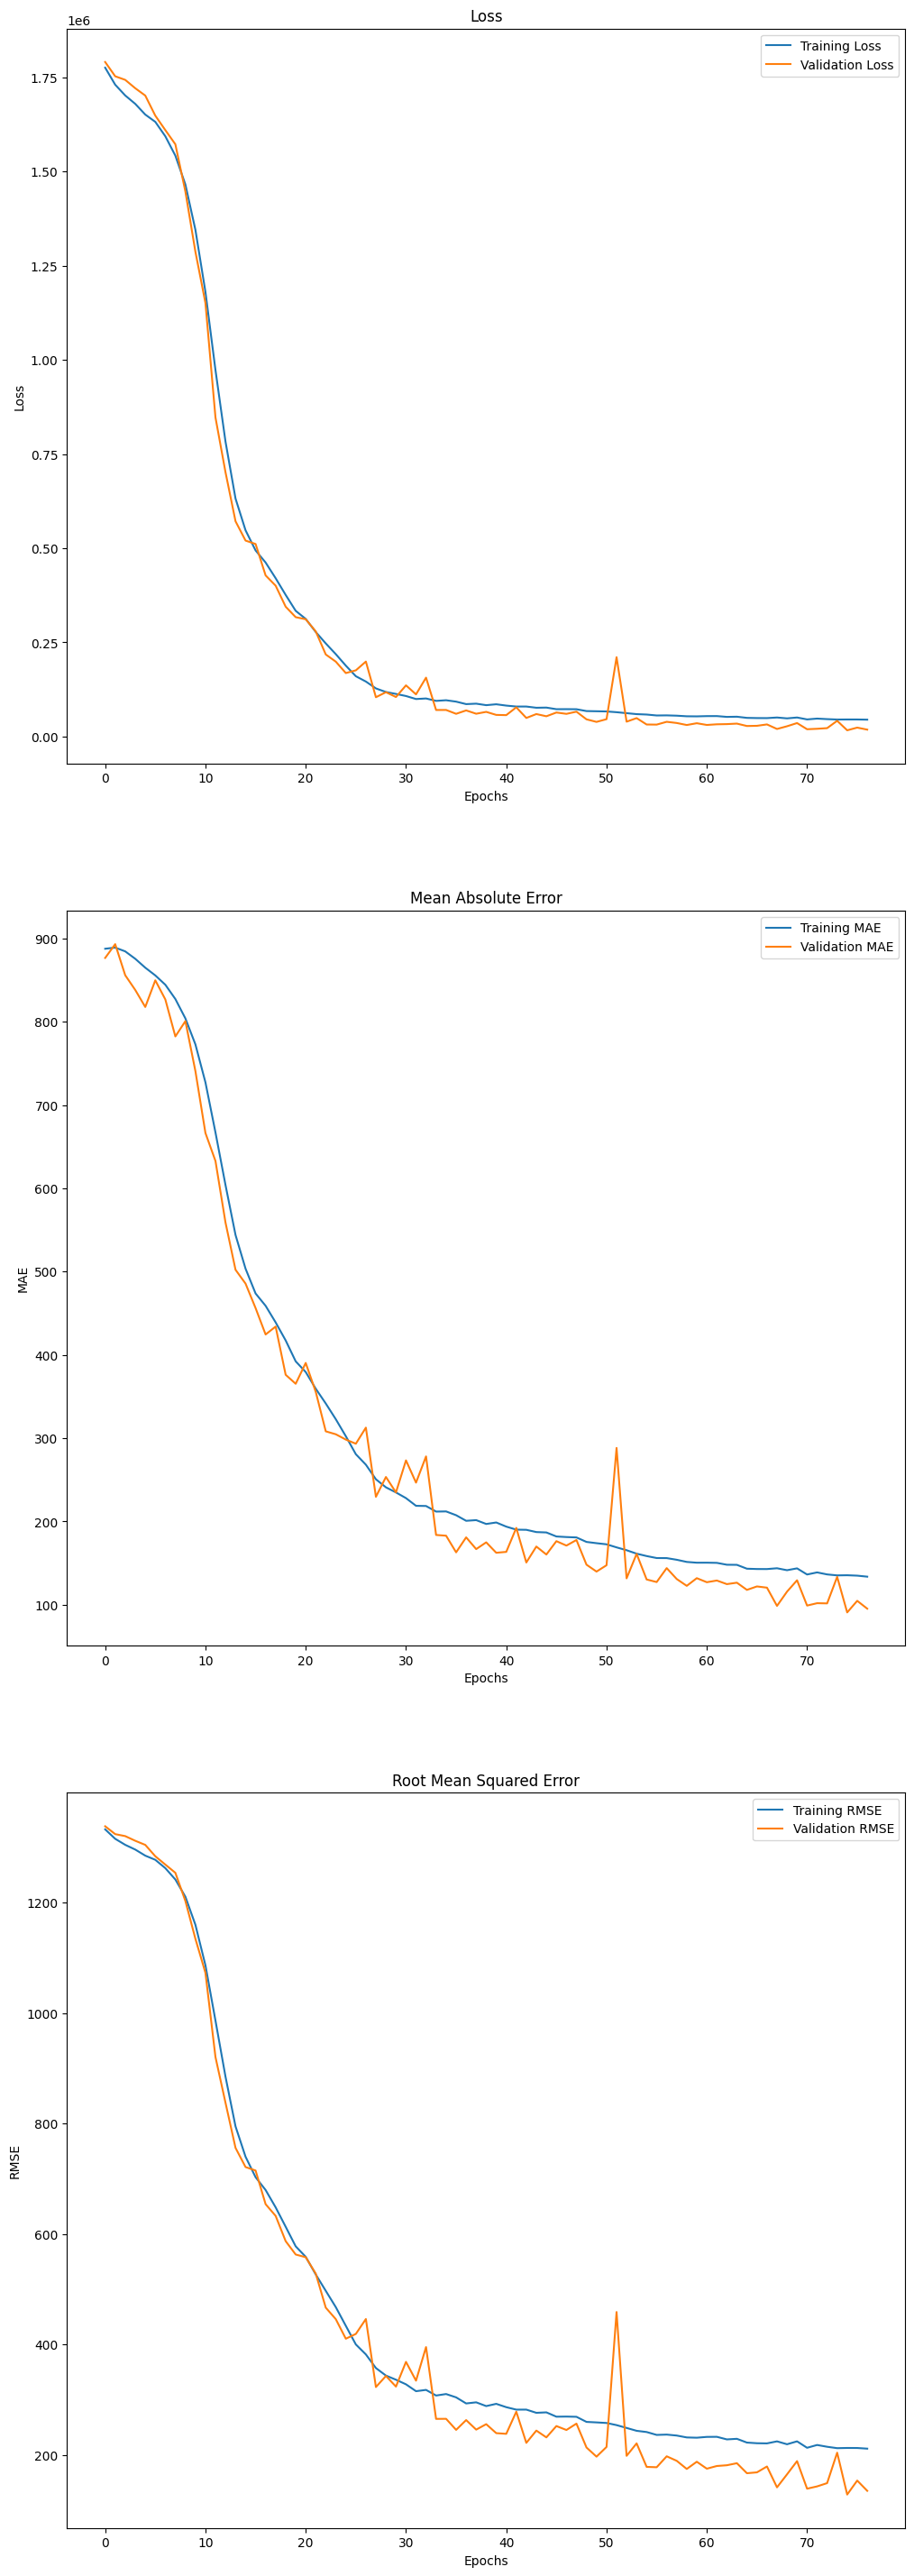

In [172]:
# Accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 36))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# PM 4.25

In [187]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y_pm425, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(20, 3, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(64, (1, 1), activation='relu'),  # Changed kernel size
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)])  # Output layer for regression)


'''
layers.Input(shape=(20,3,3)),
layers.Rescaling(1./255),
layers.Conv2D(10, (2, 2), activation='relu'),  # Use smaller kernel size
layers.MaxPooling2D((2, 1)),      # Pooling layer
layers.Conv2D(20, (2, 2), activation='relu'),  # Use smaller kernel size
layers.GlobalAveragePooling2D(),   # Use global pooling instead of flattening
layers.Dense(20, activation='relu'),
layers.Dense(1)  # Output layer for regression
'''


def mean_absolute_error_custom(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_multivariate(y_true, y_pred):
    # Calculate RMSE for each target variable
    rmse_values = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
    return rmse_values


model.compile(optimizer='nadam', loss='mean_squared_error', metrics =['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_55 (Rescaling)        │ (None, 20, 3, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 20, 3, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 10, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 5, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 5, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_50     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
history = model.fit(X_train, y_train, epochs=300, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/300
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 88946.0156 - mae: 187.3271 - root_mean_squared_error: 297.9945 - val_loss: 83252.9141 - val_mae: 185.5453 - val_root_mean_squared_error: 288.5358
Epoch 2/300
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 81596.0000 - mae: 191.0455 - root_mean_squared_error: 285.6128 - val_loss: 82311.1328 - val_mae: 191.0359 - val_root_mean_squared_error: 286.8992
Epoch 3/300
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 78550.4062 - mae: 189.4310 - root_mean_squared_error: 280.2536 - val_loss: 82301.1484 - val_mae: 185.9906 - val_root_mean_squared_error: 286.8818
Epoch 4/300
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 76964.0078 - mae: 187.4602 - root_mean_squared_error: 277.3684 - val_loss: 79891.2812 - val_mae: 190.4869 - val_root_mean_squared_error: 282.6505
Epoch 5/300
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 77820.1484 - mae: 188.4300 - root_mean_squared_error: 278.9407 - val_loss: 77959.0938 - val_mae: 189.5236 - val

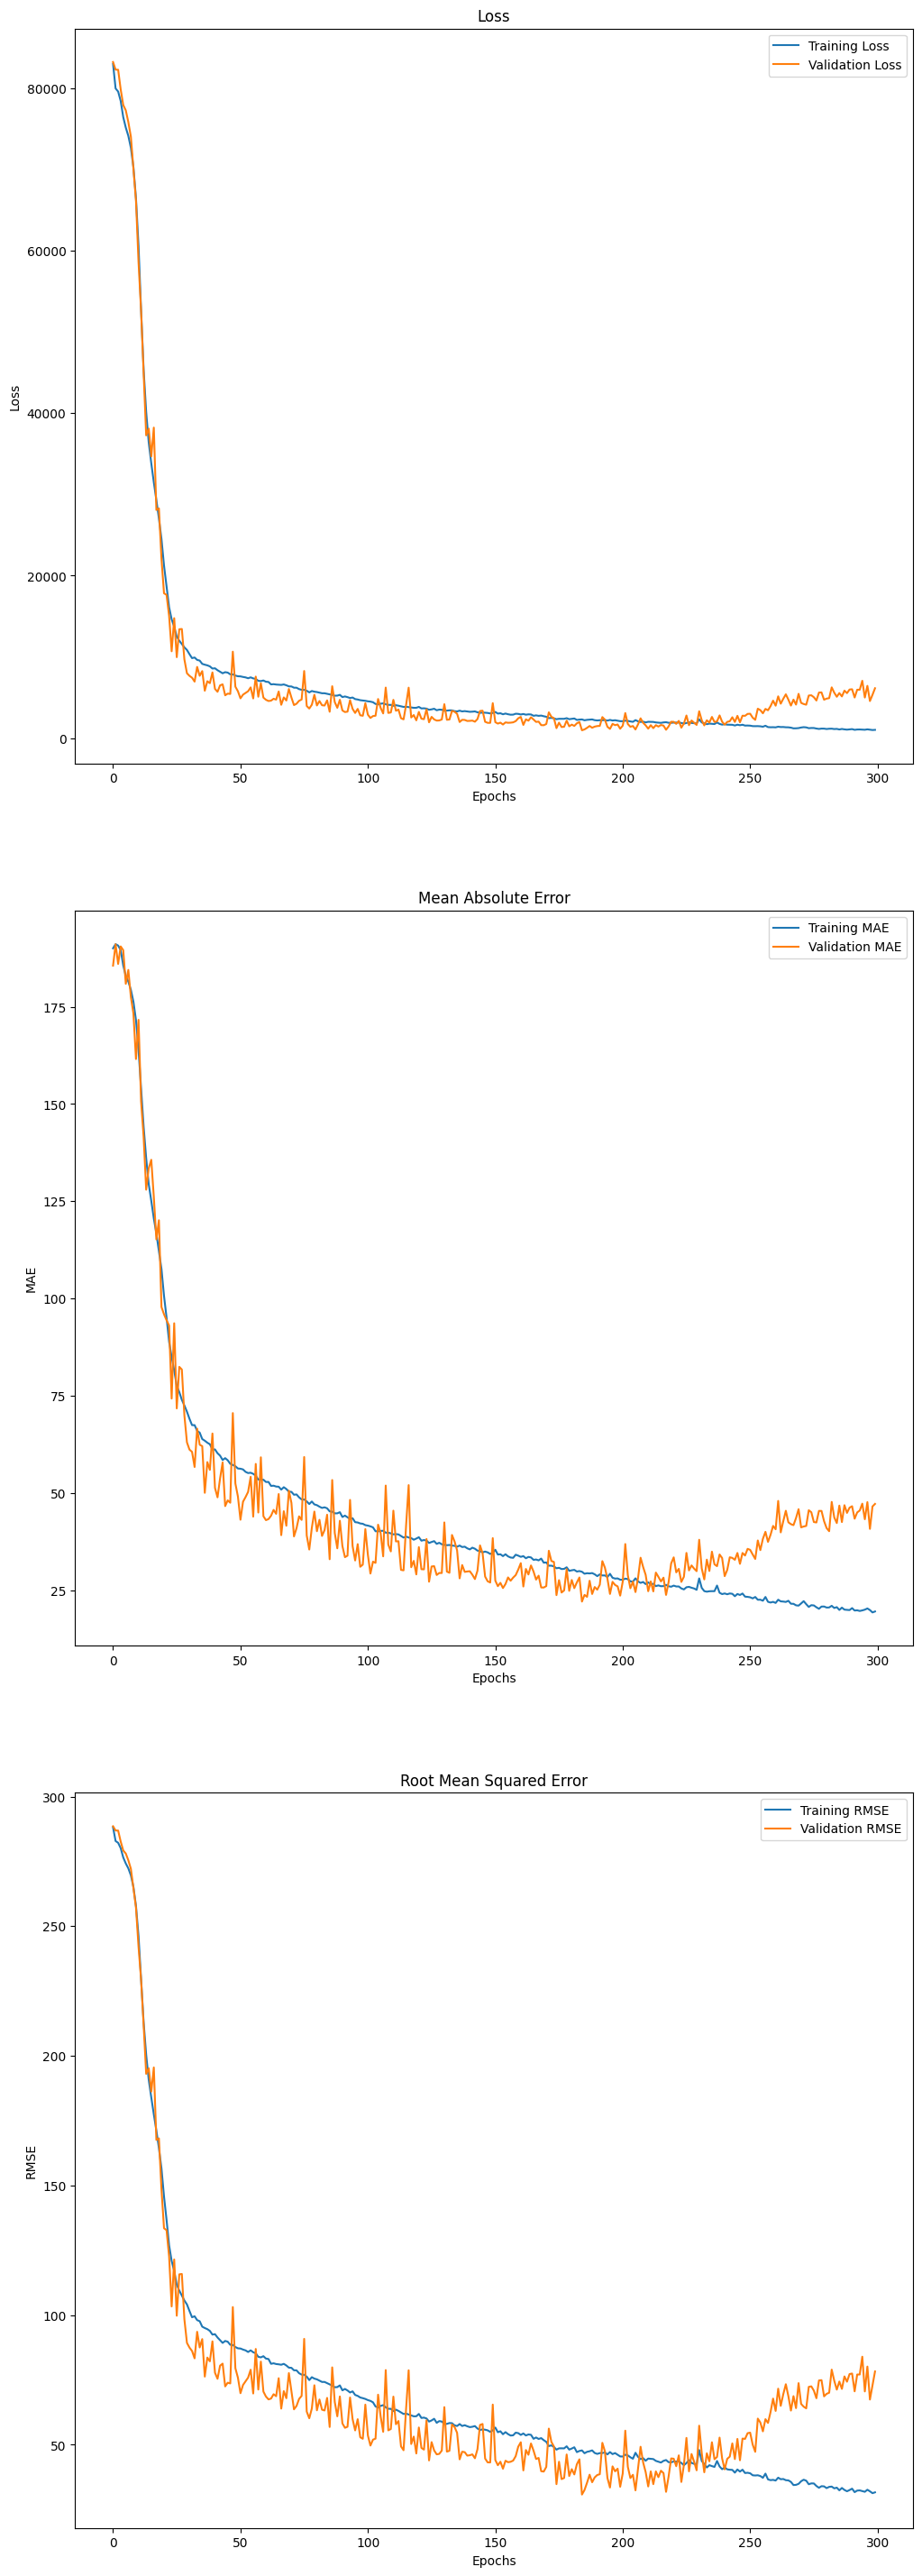

In [189]:
# Accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 36))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()